# Gathering Insights from airbnb city data for Seattle using Data science and Machine Learning

### Business Understanding

Airbnb is an online marketplace for property rentals. It provides a platform for hosts to accommodate guests with short term lodging.

Hosts on Airbnb have to set a price for their listing. Hosts also have the option to set custom prices for specific nights, weeks or months. Setting a price is left to the discretion of the host. For someone new, setting a reasonable listing price will seem daunting without an understanding of the rental landscape of their city or location. 

Potential hosts on Airbnb need to have an understanding of what features provide an indication of price at their location so that they themselves can make informed pricing decisions. Considering needs of the hosts, I am interested in answering the following questions:

1. How can we predict listing prices? What factors influence listing prices in Seattle?
2. How do prices vary with time at specific locations in Seattle?
3. How does price 

These questions will help a new host understand how prices are correlated to different features including time and location, allowing for more informed decisions in price setting. 

The client, a new host on airbnb, needs to set a reasonable price for their listing. A predictive model needs to be developed that can predict listing prices given a set of relevant features. This model needs to have a fit score of > 0.90 on the train data set and a cross validation rmse of < standard deviation of pricing data. 

For this project, I will use data analysis tools and machine learning to answer the above questions and develop a predictive model for listing prices. I will work with the open source airbnb data for Seattle for the year 2016. Data is available at Inside Airbnb [here](https://www.kaggle.com/airbnb/seattle)

### Data Understanding

We already have relevant data to work with. We need to:

1. Fetch the data and load it in our workspace
2. Explore, clean and format the data
3. Use this data to answer our questions of interest

#### Get the required packages

In [1]:
# The anaconda environment used here comes with python 3.6 and all the necessary packages installed except for basemap which
# needs to be installed and scikit-learn which needs to be updated to v0.21

import os

# import functions module
from functions import *

# Data retrival and handling packages
import pandas as pd
import pandas_profiling
import numpy as np

# Data visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap
import statsmodels.api as sm

# Get scikit learn tools for machine learning
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

%matplotlib inline
sns.set(style='ticks')

import warnings
warnings.filterwarnings('ignore')

#### Fetch airbnb city data from the local repository


In [2]:
# get calendar and listings data (see get_airbnb_data in functions.py)
calendar = get_airbnb_data('seattle', 'calendar')
listings = get_airbnb_data('seattle', 'listings')

calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [3]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


#### 2.3 Inspect, clean and format Calendar data 



In [4]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [5]:
print('price missing ratio: ', calendar.price.isnull().mean())
print('availability ratio of non null price listings: ', (calendar[calendar.price.notnull()].available=='t').mean())

price missing ratio:  0.32938998399793334
availability ratio of non null price listings:  1.0


In [6]:
# there are four columns
# 'price' needs to be converted to a numeric type
# missing values in 'price' indicate unavailablity of a listing
# at a specific date, NOT unavailability of data; imputing is not required in this context
# 'date' needs to be converted to a datetime format
# 'available' is redundant since there is no variation in values for non null price entries

calendar['date'] = to_date_time(calendar.date)

calendar['price'] = to_numeric(calendar.price)

calendar.drop('available', axis=1, inplace=True)

calendar.head()

,listing_id,date,price
0,241032,2016-01-04,85.0
1,241032,2016-01-05,85.0
2,241032,2016-01-06,NaN
3,241032,2016-01-07,NaN
4,241032,2016-01-08,NaN


#### 2.4 Inspect, clean and format listings data

In [7]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

In [8]:
# There are too many columns to inspect manually
# We need to generate a profile report
pandas_profiling.ProfileReport(listings)

Number of variables,92
Number of observations,3818
Total Missing (%),8.5%
Total size in memory,2.7 MiB
Average record size in memory,736.0 B
Numeric,25
Categorical,51
Boolean,0
Date,0
Text (Unique),2
Rejected,14


In [9]:
# In predictive modeling, too many features are computationally expensive
# and can produce models that don't generalize well. These 'bad' features need
# to be removed

# Features with the following characteristics are removed:
# 1) very high cardinality (i.e. amenities, cleaning fee)
# 2) very high null ratio (i.e. availability_30, first_review)
# 3) constant value (i.e. calendar_last_scraped, country_code)
# 4) very high skewness (i.e. minimum_nights)

# this selection process is manual and
# should be performed with cation 

# selected features by type
num_cols = ['latitude','longitude','accommodates',
            'bathrooms', 'bedrooms', 'beds', 'price','number_of_reviews',
            'reviews_per_month', 'availability_365', 'guests_included']

cat_cols = ['host_response_time', 'host_is_superhost', 'host_identity_verified',
            'neighbourhood_group_cleansed', 'property_type', 'room_type',
            'instant_bookable', 'cancellation_policy']

id_col = ['id']

listings = listings[num_cols+cat_cols+id_col]

# get pricing data from the calendar dataset
# we don't use pricing data of the listings dataset
# as each price entry is the median of daily prices for
# that listing BUT mean is a much better indicator of
# average in this context
listings['price'] = calendar.groupby('listing_id', sort=False, as_index=False)['price'].mean().drop('listing_id', axis=1)

listings.head(5)

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,reviews_per_month,availability_365,guests_included,host_response_time,host_is_superhost,host_identity_verified,neighbourhood_group_cleansed,property_type,room_type,instant_bookable,cancellation_policy,id
0,47.636289,-122.371025,4,1.0,1.0,1.0,85.000000,207,4.07,346,2,within a few hours,f,t,Queen Anne,Apartment,Entire home/apt,f,moderate,241032
1,47.639123,-122.365666,4,1.0,1.0,1.0,170.931271,43,1.48,291,1,within an hour,t,t,Queen Anne,Apartment,Entire home/apt,f,strict,953595
2,47.629724,-122.369483,11,4.5,5.0,7.0,1301.818182,20,1.15,220,10,within a few hours,f,t,Queen Anne,House,Entire home/apt,f,strict,3308979
3,47.638473,-122.369279,3,1.0,0.0,2.0,100.000000,0,NaN,143,1,NaN,f,t,Queen Anne,Apartment,Entire home/apt,f,flexible,7421966
4,47.632918,-122.372471,6,2.0,3.0,3.0,462.739726,38,0.89,365,6,within an hour,f,t,Queen Anne,House,Entire home/apt,f,strict,278830


#### 2.5 Question: Is there time based variation in listing prices in Seattle?

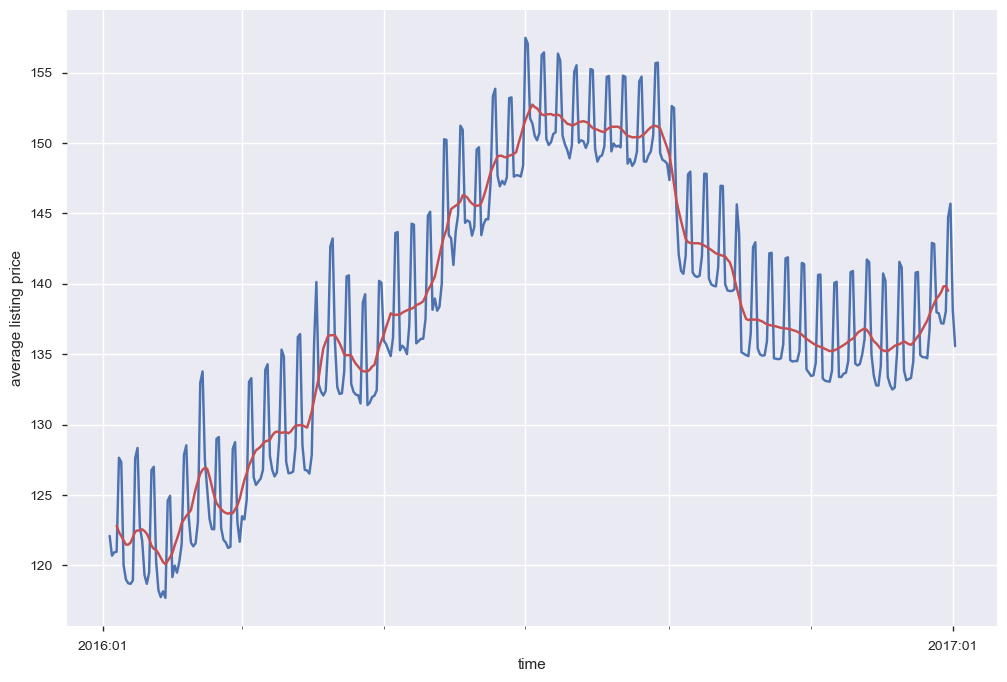

In [11]:
# for each date, calculate mean price over all available property listings
df = pd.DataFrame(calendar.groupby('date')['price'].mean())

# decompose observed time series into its 3 components: trend, seasonality and noise
decomposition = sm.tsa.seasonal_decompose(df, model='additive')    # price = Level + Trend + Seasonality + Noise

# Create a figure and axis for the plot (see functions.plot_time_series in functions.py)
fig, ax = plot_time_series(1)

# plot time series and trend on same axis
ax.plot(df.index, df.values, '-b')
ax.plot(decomposition.trend.index, decomposition.trend, "-r")

plt.show()

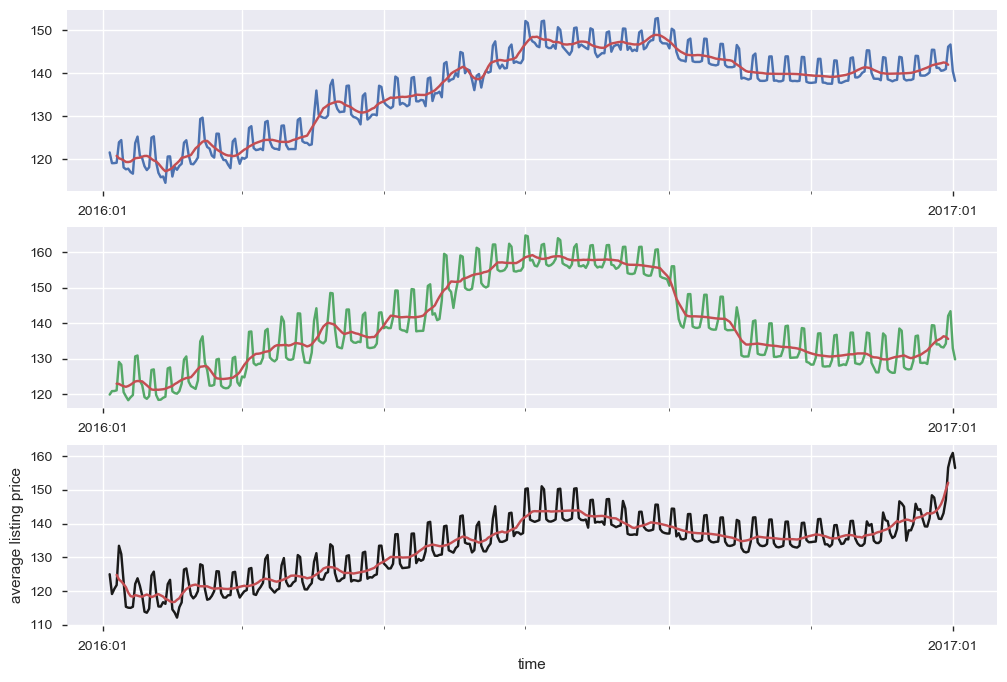

In [12]:
# To better illustrate time based variation, we plot 
# time series and trends for each of the three major
# property types: house, apartment and townhouse

df_list = listings.copy()
df_cal = calendar.copy()

# merge calendar copy with listings copy,
# group by property_type and date
# and calculate mean price for each property type and at each date
df_list.rename(columns={'id': 'listing_id'}, inplace=True)
df_list_sub = df_list[['listing_id', 'property_type']][df_list.property_type.isin(['House', 'Apartment', 'Townhouse'])]
df_cal = df_cal.merge(df_list_sub, how='left', on='listing_id')
df = df_cal.groupby(['property_type', 'date'])['price'].mean().unstack(level=0)

decomposition_1 = sm.tsa.seasonal_decompose(df['House'], model='additive')
decomposition_2 = sm.tsa.seasonal_decompose(df['Apartment'], model='additive')
decomposition_3 = sm.tsa.seasonal_decompose(df['Townhouse'], model='additive')

fig, ax = plot_time_series(3)

ax[0].plot(df['House'].index, df['House'].values, '-b')
ax[0].plot(decomposition_1.trend.index, decomposition_1.trend, '-r')

ax[1].plot(df['Apartment'].index, df['Apartment'].values, '-g')
ax[1].plot(decomposition_2.trend.index, decomposition_2.trend, '-r')

ax[2].plot(df['Townhouse'].index, df['Townhouse'].values, '-k')
ax[2].plot(decomposition_3.trend.index, decomposition_3.trend, '-r')

plt.show()

Subplots:
Top: houses;
Middle: apartments;
bottom: townhouses

The time series plots show that there is time based variations in the average listing prices. Looking at the overall plot, we see that the average listing price starts out low at beginning of the year, rises through spring and becomes highest in the summer months (July-August-September). Looking at each property type seperately, we see a similar trend. Notable differences are that houses retain the maximum summer average price even after September while apartments have the most noticeable fall. It is also interesting to note that apartments peak at a higher average listing price than houses. More insight is needed to explain this otherwise odd occurence. A new host should set a dynamic pricing scheme to match the observed trends for a more competitive edge

#### 2.6 Which features are most related to price?


In [13]:
df_list = listings.copy()
all_cols = num_cols+cat_cols

# discretize numerical features for numerical-categorical corelation calculations
for col in num_cols:
    df_list[col] = pd.qcut(df_list[col], 12, duplicates='drop')
    df_list[col] = df_list[col].astype(str).values

# convert categorical features to type 'categorical' for faster evaluations
for col in cat_cols:
    df_list[col] = df_list[col].astype('category')

# make empty n x n array and populate it with
# phi coefficients calculated using the get_phi_score
# function from the functions module
# Set max coefficient to 1.0
phi_coeff = np.empty((len(all_cols), len(all_cols)))
for i in range(len(all_cols)):
    for j in range(len(all_cols)):
        if i==j:
            phi_coeff[i,j]=1.0
        else:
            conf_matrix = pd.crosstab(df_list[all_cols[i]], df_list[all_cols[j]])
            phi_coeff[i,j] = get_phi_score(conf_matrix)
            if phi_coeff[i,j]>1.0:
                phi_coeff[i,j]=1.0

corr = pd.DataFrame(phi_coeff, columns=all_cols, index=all_cols)

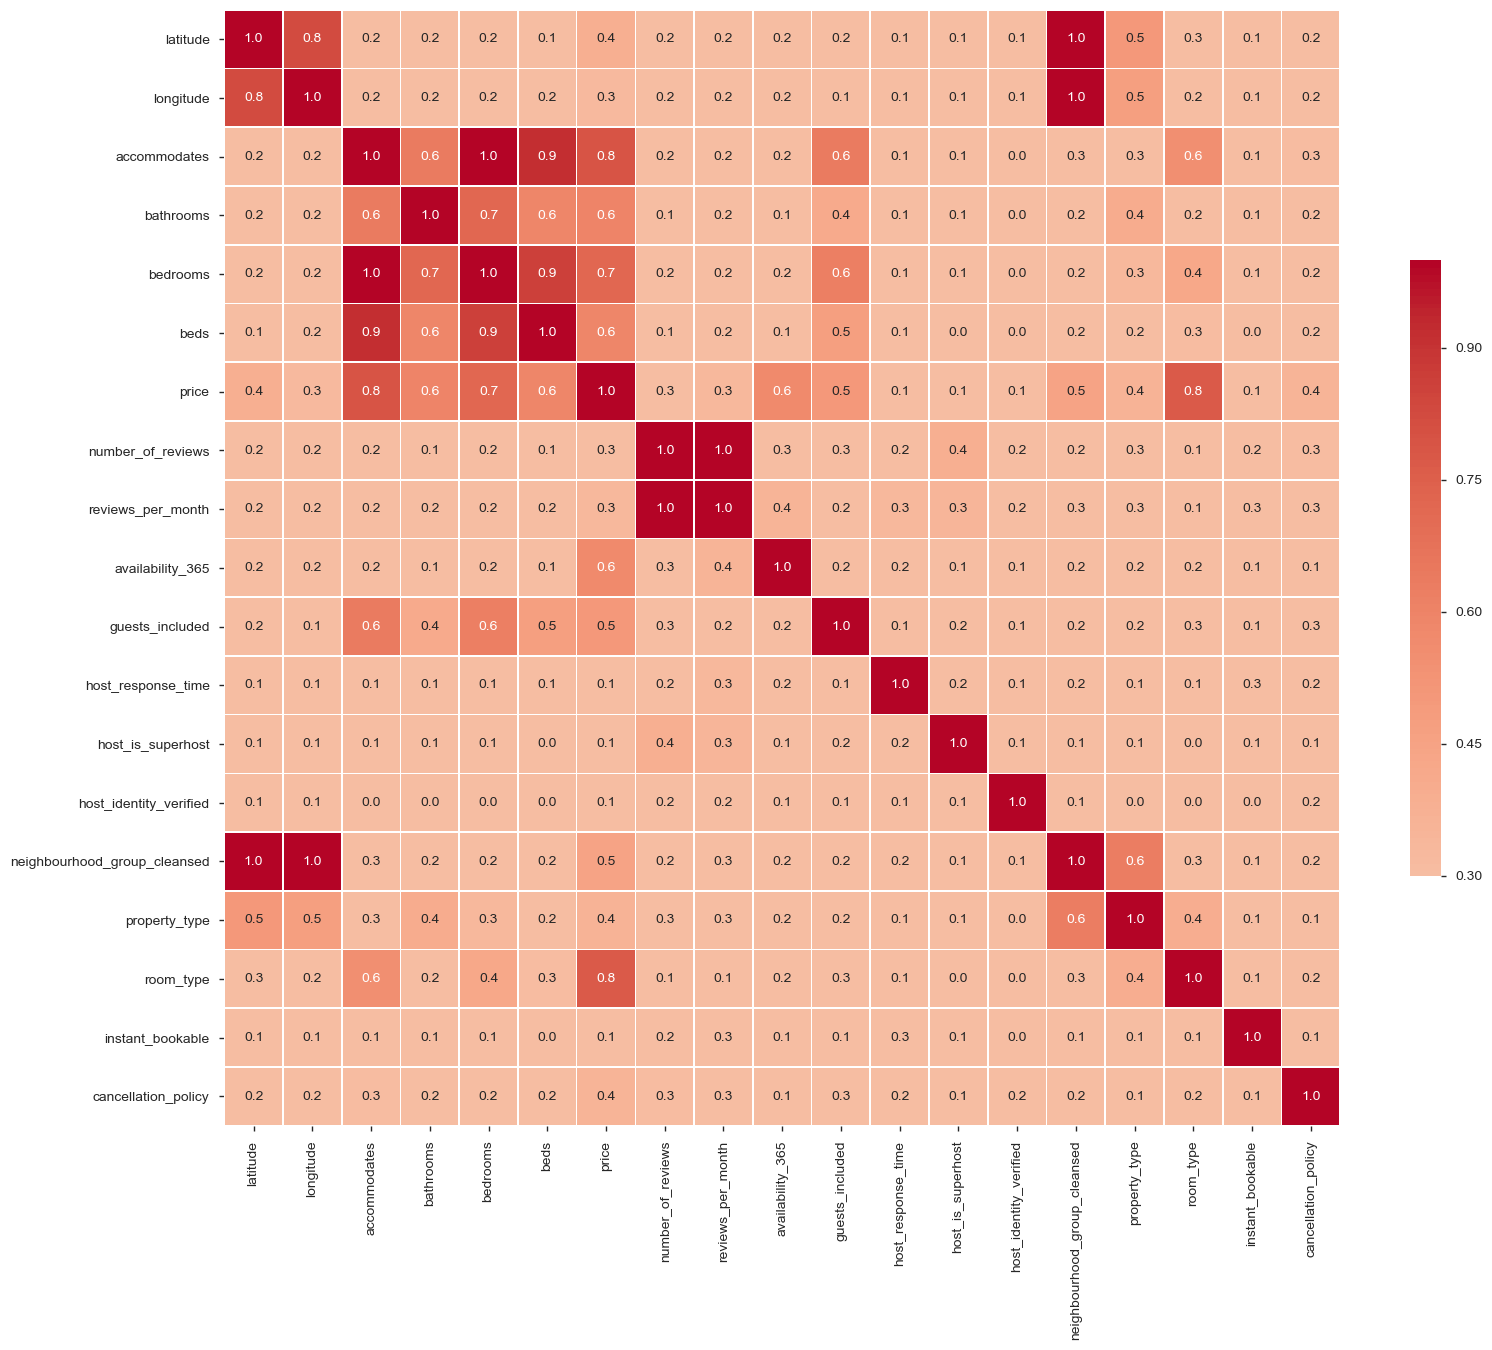

In [14]:
#COntruct heatmap using the corr matrix
g = sns.heatmap(corr, vmin=0.3, vmax=1.0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.1f', cmap='coolwarm')
sns.despine()

g.figure.set_size_inches(18,16)

plt.show()

In the above heatmap, a number closer to 1 means strong correlation between variables and a number closer to 0 means weak correlation. Looking at the row for price, we see that price is most correlated with accommodates, room_type, bedrooms, beds, bathrooms, availability_365, guests_included, neighbourhood and property_type and location (latitude) in that order. When setting a pricing scheme for their property, a new host should pay close attention to these features.
Note that in the above heatmap, only the intensity of correlation can be observed not if the correlation is positive or negative. Another heatmap for numerical features only is constructed next using the Pearson's R method

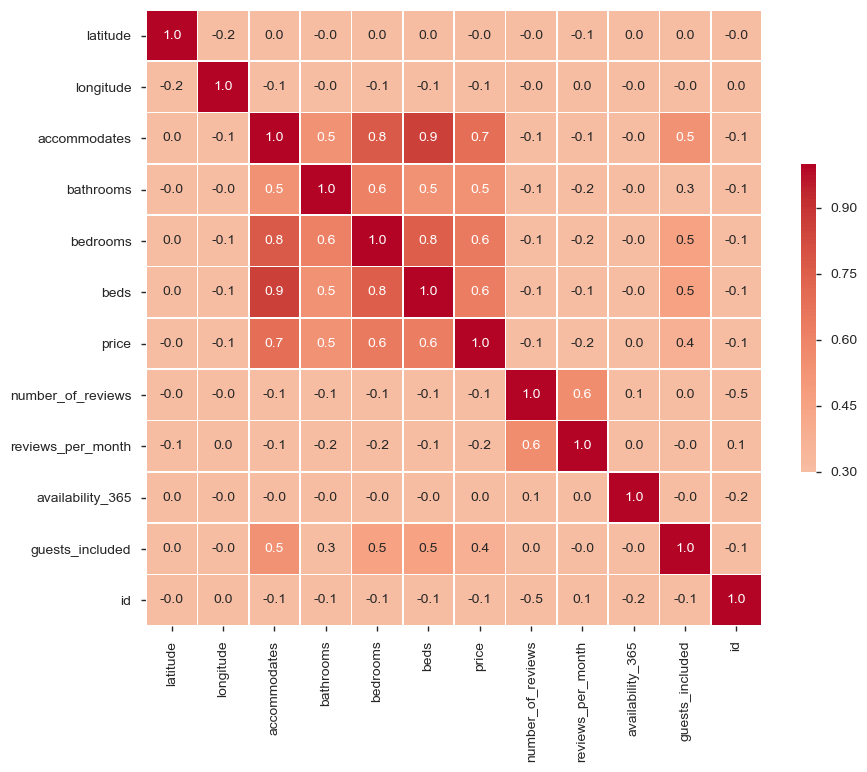

In [15]:
corr = listings.corr()
g = sns.heatmap(corr, vmin=0.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.1f', cmap='coolwarm')
sns.despine()

g.figure.set_size_inches(10,8)

plt.show()

We see that the 5 most correlated numerical features from the previous heatmap (accommodates, bedrooms, beds, bathrooms, guests_included) are actually positively correlated to price.

A visual aid illustrating these positive correlations would help in expanding our understanding of the features. A pairplot is constructed next

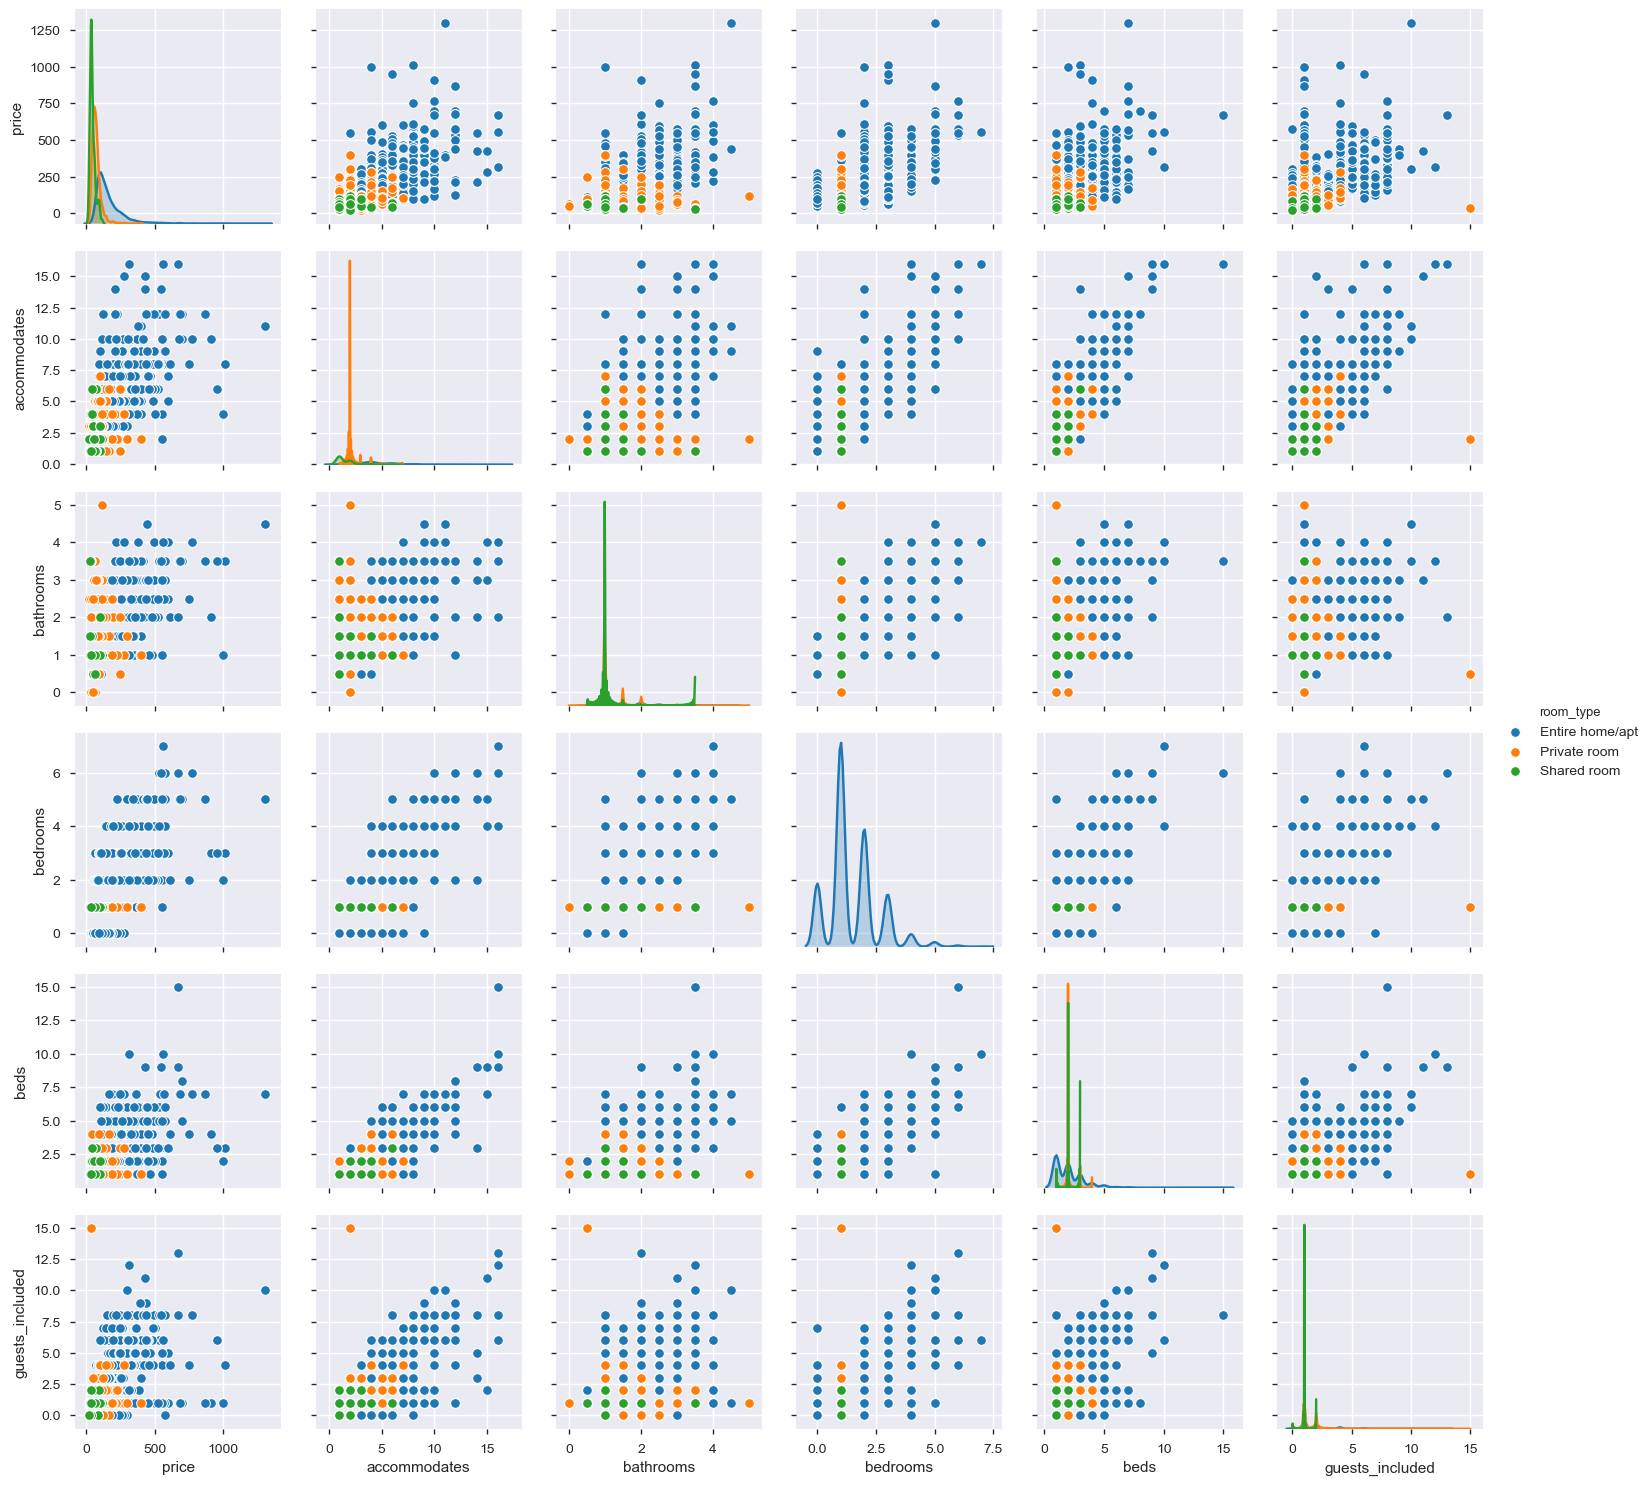

<Figure size 1200x1000 with 0 Axes>

In [16]:
filtered_listings = listings[listings['property_type'].isin(['House', 'Apartment', 'Condominium', 'Townhouse'])].copy()

g = sns.pairplot(filtered_listings[['price', 'accommodates', 'bathrooms',
                           'bedrooms', 'beds', 'guests_included', 'room_type']], hue='room_type')
sns.despine()
plt.figure(figsize=(12,10))
plt.show()

The inclusion of the most correlated categorical feature, room type, gives us more perspective. The following observations can be made from the pair plot:

1. price increases with an increase in accommodates, number of beds, number of bedrooms and number of guests
2. accommodates shows the strongest positive and linear correlation with price
3. accommodates is also strongly correlated to number of beds, bedrooms, bathrooms and guests included, even more so than price
4. Entire homes/apartments have much higher prices than shared rooms and private rooms
5. price is highly skewed to the left for shared and private rooms and lesser skewed for entire house/apartmnts
6. Number of bedrooms is multimodal for entire houses/apartments; there is only one bedroom for shared and private room types

Observations 2 and 3 are interesting in that they suggest that bedrooms, beds, bathrooms and guests_included determine the number of accommodates and in turn accommodates determine the price. If this is true, the other four features are redundant and excluding them during price modeling would yield a better model. 

Observations 4 and 5 suggests that although prices for entire houses/apartments are more than shared and private rooms, the count of entire home/apartment type is low. Hence, in order to gauge the effect of location on price, we will need to neutralize the average effect of room type by setting the weighted average price with respect to room type equal for all room types

#### 2.7 Question: Is there location based variation in listing prices in Seattle?


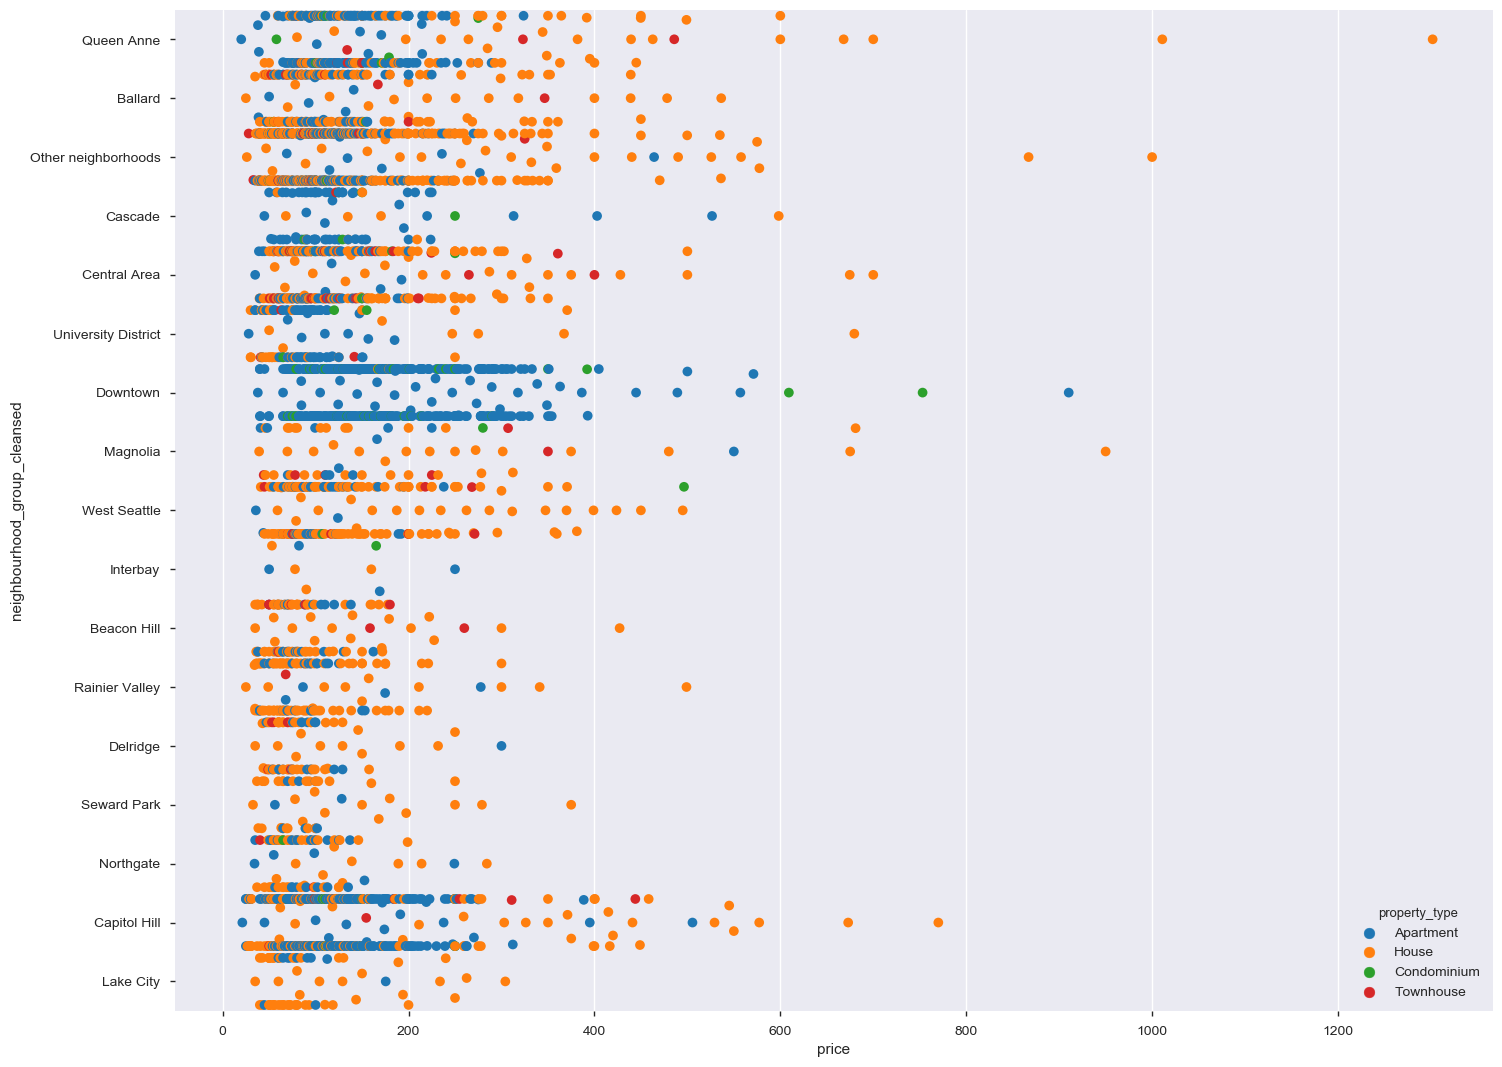

In [17]:
# Construct a swarmplot to illustrate correlation between neighbourhood and listing prices
g = sns.swarmplot(y='neighbourhood_group_cleansed',
                 x='price',
                  hue='property_type',
                 data=filtered_listings,
                 size=7)
sns.despine()
g.figure.set_size_inches(17,13)
plt.show()

From the swarmplot, we observe that:

1. Certain neighbourhoods are richer in one property type; for example Downtown is mostly apartments and Inter Bay is mostly houses.
2. Average listing price shifts across neighbourhoods as some listing concentrations extend more to the right than others. However, there isn't great variation in these averages as we can easily group the neighbourhoods into maximum 3 or 4 categories based on average prices. 
3. Almost all outliers in each neighbourhood are houses except for those in Downtown.
4. houses and apartments dominate the rental landscape.

Observation 1 suggests a strong correlation between property type and neighbourhood. Observation 2 however, suggests a weak relationship between neighbourhood and price. There is also a very weak correlation between property type and price as there is no indication of a clear pattern. For predictive modeling, we may choose to omit  property type completely as any effect that it might have on price is reflected in neightbourhood location anyway.

Next we analyze the relationship between location (latitude) and price

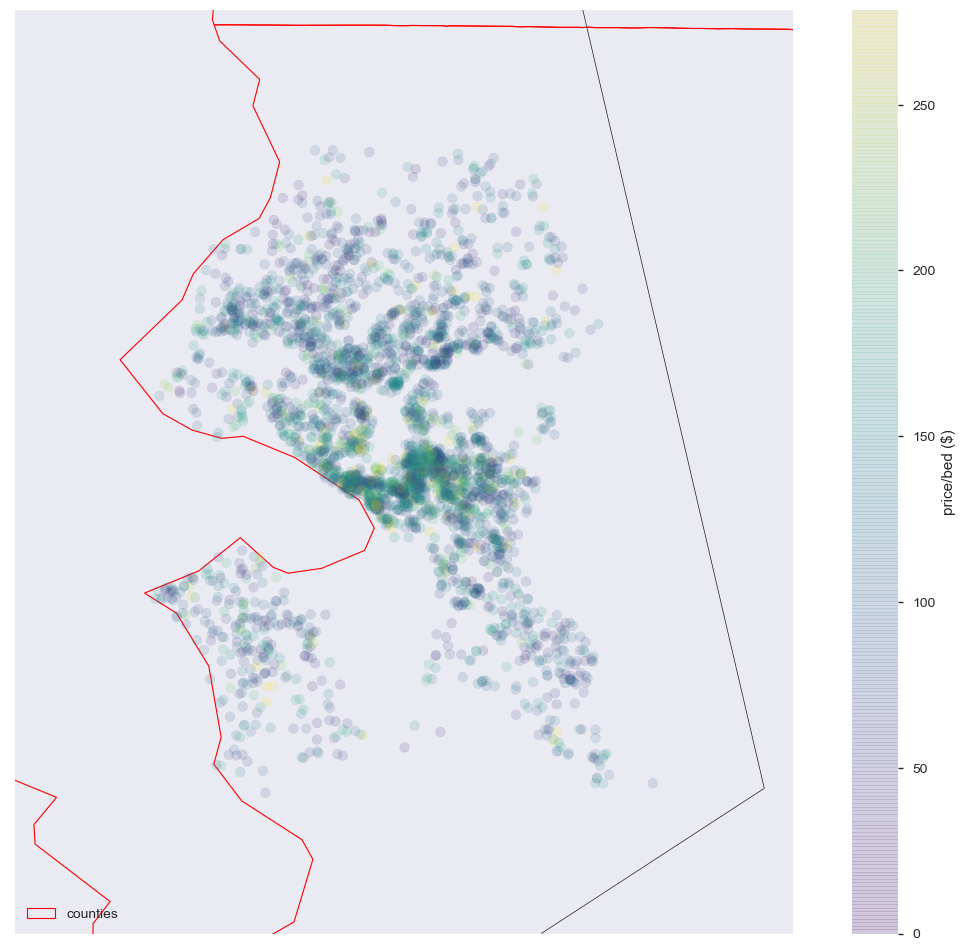

In [18]:
df_list = filtered_listings[['latitude', 'longitude', 'price', 'beds', 'room_type', 'property_type']].copy()

df_list.fillna(df.mean(), inplace=True)

#calculate weighted average prices for each room type
count_gpby_property_room = df_list.groupby(['property_type', 'room_type'])['price'].size().unstack()
price_gpby_property_room = df_list.groupby(['property_type', 'room_type'])['price'].mean().unstack()
room_type_totals = count_gpby_property_room.sum()
price_weighted_totals = price_gpby_property_room*count_gpby_property_room
price_weighted_means = price_weighted_totals.sum()/room_type_totals

private_room_multiplier = price_weighted_means[0]/price_weighted_means[1]
shared_room_multiplier = price_weighted_means[0]/price_weighted_means[2]

# Modify listing prices such that weighted average price
# by room type is equal for each room type
# (neutralizing room type effect)
df_list.price[df_list['room_type']=='Private room'] = df_list.price[df_list['room_type']=='Private room']*private_room_multiplier
df_list.price[df_list['room_type']=='Shared room'] = df_list.price[df_list['room_type']=='Shared room']*shared_room_multiplier

# Use price/beds to neutralize the effect of beds
# Since beds is correlated too accommodates, this also
# neutralizes the effect of accommodates
df_list['price/beds'] = df_list.price/df_list.beds

latitudes = df_list.latitude
longitudes = df_list.longitude
price_distribution = df_list['price/beds']

# Call the functions.plot_geographical to create a basemap
# of Seattle and overly it with listings in scattered form
plot_geographical(latitudes, longitudes, price_distribution)

We can divide up the rental landscape of Seattle by location into 3 groups. 

To the North, there is a widespread low priced region. Average price seems to be around 100/bed.
Coming down South, there are two high priced concentrated regions; one borders the coast and the other is just to its North. Average prices seem to be around 200/bed. To the South, there are two vertical stretches of very low priced regions and there seems to be less outliers. Average price is <100/bed. 

The map and our observations reinforce our hypothesis that correlation between location and price might be weak.
Regardless, a new host should be aware of the listing prices at their location.

### Data Preparation

Now that we have understood our data and gained insights into the rental landscape in Seattle, we can use these insights to develop a predictive model for rental prices

#### 3.1 Train and Test Sets

In [19]:
# select relevant data based on analyses from the preceding sections
cols_ml = ['price', 'latitude','longitude','accommodates', 'bathrooms', 'bedrooms', 'beds',
           'availability_365', 'guests_included', 'neighbourhood_group_cleansed',
           'property_type', 'room_type', 'instant_bookable', 'cancellation_policy']

listings_ml = listings[cols_ml].copy()
listings_ml.dropna(subset=['price'], axis=0, inplace=True)

X = listings_ml.drop('price', axis=1)
y = listings_ml['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# put a cap on y_train (prices) to reduce model variance
upper_limit = y_train.quantile(0.99)
lower_limit = y_train.quantile(0.01)

is_over_limit = y_train > upper_limit
is_under_limit = y_train < lower_limit

y_train[is_over_limit] = upper_limit
y_train[is_under_limit] = lower_limit

print('X_train dim: ', X_train.shape)
print('X_test dim: ', X_test.shape)

X_train dim:  (2978, 13)
X_test dim:  (745, 13)


#### 3.2 Data transformation

In [20]:
# divide up column labels based on feature type
num_cols = ['latitude','longitude','accommodates',
            'bathrooms', 'bedrooms', 'beds',
            'availability_365', 'guests_included']

cat_cols = ['neighbourhood_group_cleansed', 'property_type', 'room_type',
            'instant_bookable', 'cancellation_policy']

# Impute categorical features (with most frequent value) and transform them into one hot encoded arrays
cat_pipeline = Pipeline([
    ('si', SimpleImputer(strategy='constant', fill_value='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

# Impute numerical features with the respective mean values and perform a max-min standardization
num_pipeline = Pipeline([
    ('si', SimpleImputer(strategy='mean')),
    ('ss', StandardScaler())
])

transformers = [('cat', cat_pipeline, cat_cols),
                ('num', num_pipeline, num_cols)]

ct = ColumnTransformer(transformers=transformers)

# Transform the train and test sets
X_train_prepared = ct.fit_transform(X_train)
X_test_prepared = ct.transform(X_test)

### 4.0 Modeling

We have to select models to train on our train set. Then, we need to evaluate the models on the same train data to select the best model.

In [21]:
# Initialize three INDEPENDENT models
lin_reg = LinearRegression()
svm_reg = SVR()
rnd_reg = RandomForestRegressor()

# fit models on train data
# Evaluate cross validation scores on train set
# Lower CV score means the model is likely to generalize better on new instances
# Evaluate fit score on train set
# A high fit score means the model fits very nicely on the train (might not generalize better though)
# choose the best model
cv_scores = []
fit_score = []
for model in (lin_reg, svm_reg, rnd_reg):
    model.fit(X_train_prepared, y_train)
    cv_score = cross_val_score(model, X_train_prepared, y_train, cv=3, scoring='neg_mean_squared_error')
    cv_scores.append(np.sqrt(-cv_score.mean()))
    fit_score.append(model.score(X_train_prepared, y_train))
    
print('linear model - cv: ', cv_scores[0], ' fit: ', fit_score[0] )
print('support vector machine - cv: ', cv_scores[1], ' fit: ', fit_score[1])
print('random forrest regressor - cv: ', cv_scores[2], ' fit: ', fit_score[2])

linear model - cv:  50.07732180839058  fit:  0.6850568233697367
support vector machine - cv:  67.60959619240464  fit:  0.4737208356605611
random forrest regressor - cv:  48.792946851473495  fit:  0.943229004535008


### 5.0 Evaluation

We select the model that meets the evaluation criteria and run a grid search on its parameter space to select parameters that produce the best performing model

In [22]:
# RandomForrestRegressor has a fit score of > 0.90 on the train set
# and a cross validation rmse of 48.79 which is < std of prices
# Hence, we select this model and tweak its parameters
param_grid = [
    {'n_estimators': [80, 120, 160, 200], 'max_features': [0.1, 0.15, 0.20, 0.25, 0.40], 'bootstrap':[True], 'n_jobs':[-1]},
  ]

grid_search_cv = GridSearchCV(RandomForestRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')

grid_search_cv.fit(X_train_prepared, y_train)
best_predictor = grid_search_cv.best_estimator_
y_pred = best_predictor.predict(X_test_prepared)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('BEST MODEL: ', best_predictor)
print('RMSE on test set: ', rmse)

BEST MODEL:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.25, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)
RMSE on test set:  58.628074864182835


### 6.0 Deployment

If we are satisfied with evaluations, we can move ahead with model deployment. In this case, deployment could mean integration of this model in a webapp's infrastructure, allowing new hosts to interact with this app to predict appropriate listing prices. To illustrate how this works, I've included an example listing below

In [23]:
# made up listing to test our 'best_predictor' from above
# It's a very nice HOUSE in the DOWNTOWN area. The ENTIRE
# home is up for rent. Seems like it go uo for quite a lot
# lets see what the model predicts
new_listing_features = pd.DataFrame([['Downtown', 'House', 'Entire home/apt', 't', 'flexible',
                                      47.6, -122.315, 8, 4, 4, 5, 300, 5]],
                                   columns=cat_cols+num_cols)
                                   
new_listing_transformed = ct.transform(new_listing_features.iloc[:1,:])
new_listing_price = best_predictor.predict(new_listing_transformed)
new_listing_price[0]

312.94490283668597

That is indeed a very high price per night. 

### Conclusion

Through the data science process, we have indentifed features that a new host should be aware of when coming up with a price for their listing. We have also gained insights into how these features relate to price. Finally, we have developed a predictive model for listing prices. I'll end this discussion with a visual describing feature importances as ranked by our model.

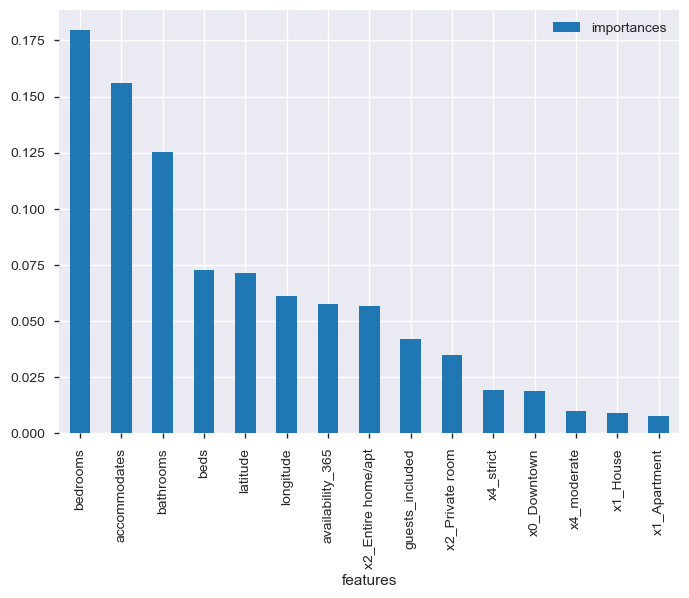

In [24]:
features = np.concatenate((ct.named_transformers_['cat'].named_steps['ohe'].get_feature_names(), num_cols))
feature_importances = best_predictor.feature_importances_
importances = pd.DataFrame({'features':features, 'importances':feature_importances}).sort_values('importances', ascending=False).set_index('features')[:15].plot.bar()
plt.show()